In [1]:
import ipywidgets as widgets
from IPython.display import display
import dataloader
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import circularPitchSpace as cps
import matplotlib.gridspec as gridspec
import features
%matplotlib inline

dataset = None

def update_dropdown_id_options(*args):
    global dataset
    selected_split = dropdown_split.value
    dataset = dataloader.MIRDataset("beatles", use_deep_chroma=True, align_chroma=False, split_nr=selected_split)
    dropdown_id.options = list(dataset.getTrackList().keys())
    dropdown_id.value = list(dataset.getTrackList().keys())[0]  # Set the default value

def update_selected_track_id(*args):
    selected_track_id = dataset.getTrackList()[dropdown_id.value]
    textbox_track_id.value = selected_track_id

# Create the dropdown widgets
dropdown_split = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6, 7],
    value = 3,
    description='Split:',
    disabled=False,
)

dropdown_id = widgets.Dropdown(
    description='Track ID:',
    disabled=False,
)

textbox_track_id = widgets.Text(
    description='Selected Track ID:',
    disabled=True,
)
update_dropdown_id_options()
update_selected_track_id()
# Register the event handlers
dropdown_split.observe(update_dropdown_id_options, 'value')
dropdown_id.observe(update_selected_track_id, 'value')

# Display the widgets
display(dropdown_split, dropdown_id, textbox_track_id)


Dropdown(description='Split:', index=2, options=(1, 2, 3, 4, 5, 6, 7), value=3)

Dropdown(description='Track ID:', options=('0101', '0104', '0209', '0306', '0308', '0401', '0408', '0506', '06…

Text(value='01_-_I_Saw_Her_Standing_There', description='Selected Track ID:', disabled=True)

load features for selected audiofile

In [2]:
feature_processor = features.FeatureProcessor(dropdown_split.value)
audiopath,target = dataset[dropdown_id.value]
ref_intervals, ref_labels = target
t,deep_chroma = feature_processor.deepChroma(audiopath,beat_alignment=False)
t,librosa_chroma = feature_processor.librosaChroma(audiopath,beat_alignment=False)


Loaded 
01_-_I_Saw_Her_Standing_There ID: 0101


find out wich key is most suited for chord recognition with the pitch space model

[0.05402861 0.04867959 0.02973035 0.04580754 0.0694702  0.09449326
 0.08846126 0.0662021  0.05603566 0.10142934 0.20078951 0.14487262]
[0.56022647 0.58829544 0.54884545 0.54708704 0.55475621 0.61614336
 0.67913945 0.55419447 0.56603628 0.53867902 0.59248071 0.65411638]


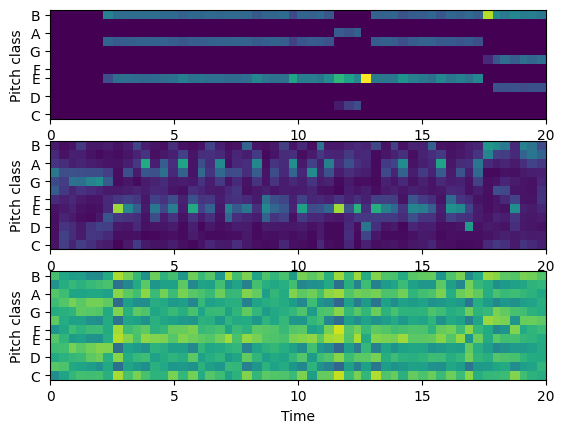

In [5]:
import librosa.display
chroma = librosa_chroma
chroma_energy = np.zeros_like(chroma,dtype=float)
for time_index in range(chroma.shape[0]):
    # calculte key related circles
    for x in cps.pitch_classes:
        n_k = x.num_accidentals
        # iterate over all chroma bins with correct index
        for i,pitch_class in enumerate(cps.pitch_classes):
            n_f = cps.sym3(49*pitch_class.chromatic_index,84,7*n_k)
            # check if real pitch is part of the key n_k
            if cps.checkIndex(n_f,n_k):
                chroma_energy[time_index,x.pitch_class_index] += chroma[time_index,i]

fig,ax = plt.subplots(3,1)
librosa.display.specshow(deep_chroma.T,cmap="viridis", y_axis="chroma",
                             ax=ax[0], x_axis='time', sr=44100, hop_length=4410)
librosa.display.specshow(chroma.T,cmap="viridis", y_axis="chroma",
                             ax=ax[1], x_axis='time', sr=44100, hop_length=4410)
librosa.display.specshow(chroma_energy.T,cmap="viridis", y_axis="chroma",
                             ax=ax[2], x_axis='time', sr=44100, hop_length=4410)
for x in ax:
    x.set_xlim(0,20)
print(chroma[200,:])
print(chroma_energy[200,:])

In [16]:
POSTPROCESSING = False

intervals = []
labels =[]
skip = []
if POSTPROCESSING:
    for i,x in enumerate(zip(est_intervals,est_labels)):
        interval,label = x
        try:
            mean_entropy = np.mean(entropy[int(10*interval[0]):int(10*interval[1])])
            if mean_entropy < 1.2:
                skip.append(i)
                est_intervals[i-1][1] = est_intervals[i+1][0]  # adjust interval bounds 
        except IndexError:
            continue
        
    for i in range(len(est_labels)):
        if i in skip:
            continue
        else:
            labels.append(est_labels[i])
            intervals.append(est_intervals[i])
    intervals = np.array(intervals)
else:
    intervals = est_intervals
    labels = est_labels
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa.display
from ipywidgets import widgets, interactive
from IPython.display import display, clear_output

def createKeyTemplate():
    template = np.array([1, 0, 0, 0, 0, 0, 0.75, 0, 0.75, 0, 0, 0, 0])  # put emphasis on tonic key
    matrix = np.zeros((12,12),dtype=float)
    for i in range(12):
        matrix[i,:] = np.roll(template,i)
    return matrix

def plotVector(ax, z):
    ax.plot([0,z.real], [0,z.imag], '-x', color="r", markersize=4)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

def plotCpsPrediction(fig,gs,chroma,chroma_index):
    r_F,r_FR,r_TR,r_DR = cps_features

    pitch_class_index = cps.estimateKey(chroma[chroma_index,:],0.1)
    ax = fig.add_subplot(gs[2, 0])
    cps.plotCircleOfFifths(ax)
    plotVector(ax,r_F[chroma_index]*1j)

    ax = fig.add_subplot(gs[2,1])
    cps.plotCircleOfFifthsRelated(ax,pitch_class_index)    
    plotVector(ax,r_FR[chroma_index,pitch_class_index]*1j)
    
    ax = fig.add_subplot(gs[2,2])
    cps.plotCircleOfThirdsRelated(ax,pitch_class_index)
    plotVector(ax,r_TR[chroma_index,pitch_class_index]*1j)
    ax = fig.add_subplot(gs[2,3])
    cps.plotCircleOfDiatonicRelated(ax,pitch_class_index)
    plotVector(ax,r_DR[chroma_index,pitch_class_index]*1j)

def plotWaveform(fig,gs,t_min, t_max,chroma_index):
    ax = fig.add_subplot(gs[1, :])
    t = np.linspace(t_min,t_max,int(t_max*44100)-int(t_min*44100))
    temp = audio[int(t_min*44100):int(t_max*44100)]
    beats = features["beats"]    
    ax.plot(t,temp/np.max(temp))
    ax.plot(t_chroma,rms/np.max(rms),'--r',linewidth=1)    
    i_min = int(10*t_min) 
    i_max = int(10*t_max) 
    entropy = calculateEntropy(chroma[i_min:i_max, :]) #calculate entropy in time bounds
    ax.plot(t_chroma[i_min:i_max],entropy/np.max(entropy),'r')
    ax.vlines(chroma_index/10, 0,1 , 'yellow')  # Red vertical line controlled by the slider
    ax.vlines(beats,0,1, 'grey', linestyle='dashed', linewidth=1)
    ax.set_xlim([t_min,t_max])
    ax.set_ylim([0,1])
    ax.grid()
    
def plotChordPrediction(t_min, t_max,t_index):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4)
    ax = fig.add_subplot(gs[0, :])

    for i, label in enumerate(ref_labels):
        if t_min <= ref_intervals[i, 0] < t_max:
            ax.vlines(ref_intervals[i, 0], -0.5, 11.5, 'grey', linestyles='dashed', linewidth=1)
            ax.text(ref_intervals[i, 0], 12.5, label, fontsize=6, horizontalalignment='center')

    for i, label in enumerate(labels):
        if t_min <= intervals[i, 0] < t_max:
            ax.vlines(intervals[i, 0], -0.5, 11.5, 'r', linestyles='dashed', linewidth=1)
            ax.text(intervals[i, 0], 14, label, fontsize=6, horizontalalignment='center', color='r')

    librosa.display.specshow(chroma.T,cmap="gray_r", y_axis="chroma",
                             ax=ax, x_axis='time', sr=44100, hop_length=4410)
    ax.set_xlabel("")
    ax.vlines(t_index, -0.5, 11.5, 'yellow')  # Red vertical line controlled by the slider
    
    for col in range(2):
        ax.set_xlim((t_min, t_max))

    chroma_index = int(t_index * 10)
    plotCpsPrediction(fig, gs, chroma_index)
    plotWaveform(fig,gs,t_min,t_max,chroma_index)
    plt.show()

def updatePlot(t_range,t_index):
    t_min, t_max = t_range
    clear_output(wait=True)
    plotChordPrediction(t_min, t_max, t_index)

# Initialize the range slider with the minimum and maximum time values
t_min_init = 0
t_max_init = t_chroma[-1]

range_slider = widgets.FloatRangeSlider(
    value=[0, 20],
    min=t_min_init, max=t_max_init, step=5,
    description='Time Range:',
    readout_format='.1f',
)

t_index_slider = widgets.FloatSlider(
    value=10,
    min=t_min_init, max=t_max_init, step=0.1,
    description='Time Index:',
    readout_format='.1f',
)

def updateTIndexSlider(*args):
    t_index_slider.min = range_slider.value[0]
    t_index_slider.max = range_slider.value[1]

updateTIndexSlider()
range_slider.observe(updateTIndexSlider, 'value')


interactive_plot = interactive(updatePlot, t_range=range_slider, t_index=t_index_slider)
output = interactive_plot.children[-1]
output.layout.height = '500'
display(interactive_plot)


interactive(children=(FloatRangeSlider(value=(0.0, 20.0), description='Time Range:', max=159.0, readout_format…

Akkordanalyse